# Code to Import Data(CSV files) in MYSQL Using Python

In [4]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sunny@123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/nares/OneDrive/Desktop/Ecommerce Project DA'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Code to Connect MYSQL with Jupyter Notebook

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            user = "root",
                            password = "Sunny@123",
                            database = "ecommerce")
cur = db.cursor()



# List all unique cities where customers are located.  

In [37]:
query = """select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["distinct_cities"])
df.head(5)

,distinct_cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [9]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are",data[0][0]

('Total orders placed in 2017 are', 90202)

# Find the total sales per category. 

In [14]:
query = """select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Categoruy","Sales"])
df

,Categoruy,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# Calculate the percentage of orders that were paid in installments.

In [19]:
query = """select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state. 

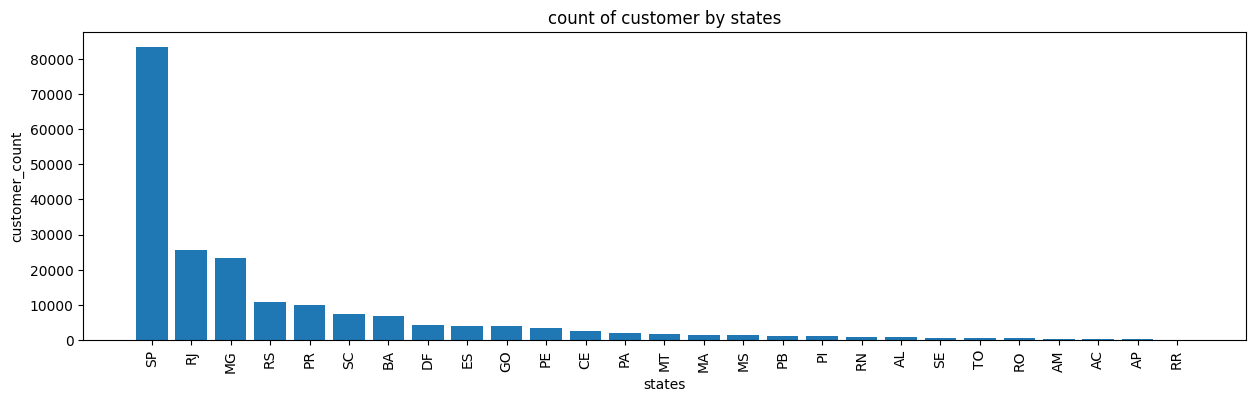

In [59]:
query = """select customer_state, count(customer_id) from customers
group by customer_state
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count",ascending = False)
plt.figure(figsize = (15,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customer by states")
plt.show()

# Calculate the number of orders per month in 2018. 

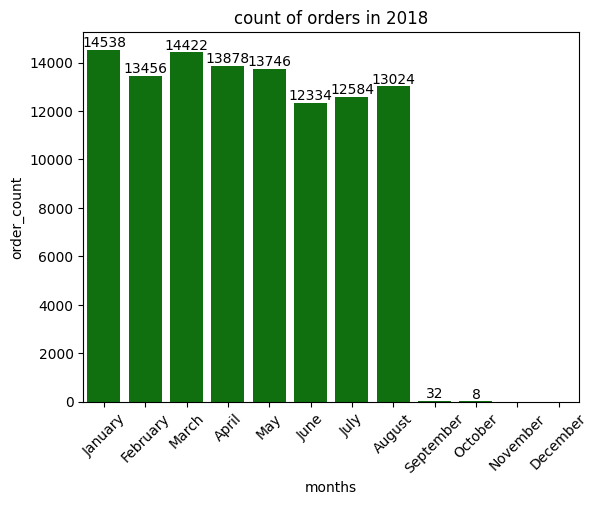

In [61]:
query = """select monthname(order_purchase_timestamp), count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","order_count"])
o = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

ax = sns.barplot(x = "months", y = "order_count", data = df,order = o, color = "green")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of orders in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city. 

In [64]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer city", "average products per order"])
df.head(10)

,customer city,average products per order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


# Calculate the percentage of total revenue contributed by each product category. 

In [8]:
query = """select upper(products.product_category) category, round(((sum(payments.payment_value))/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales_percentage desc;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "percentage_distribution"])
df.head(10)

,category,percentage_distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


# Identify the correlation between product price and the number of times a product has been purchased. 

In [14]:
import numpy as np
query = """select products.product_category, count(order_items.product_id), round(avg(order_items.price),2) from products
join order_items 
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","order_count","Average_price"])
arr1 = df["order_count"]
arr2 = df["Average_price"]

a = np.corrcoef([arr1,arr2])
print("the corelation between the product price and the number of times a product has been purchased is",a[0][-1])


the corelation between the product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

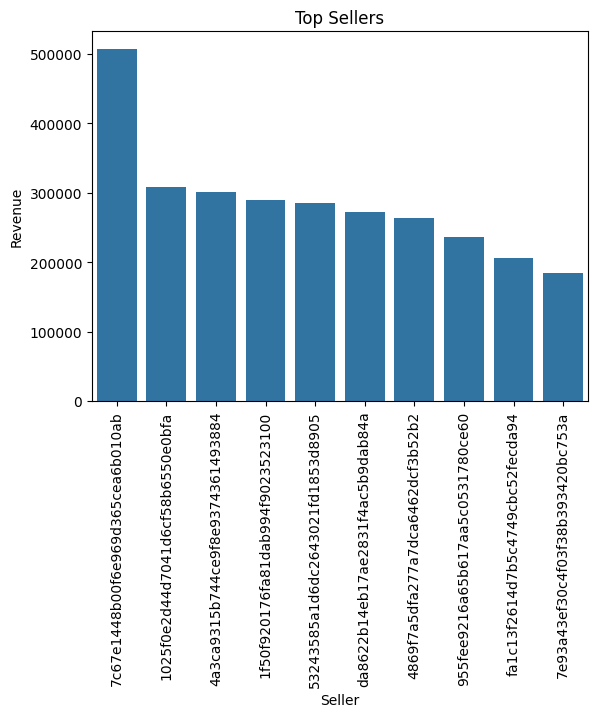

In [27]:
query = """select *, dense_rank() over (order by revenue desc) as top from (select order_items.seller_id,sum(payments.payment_value) revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Seller","Revenue","Rank"])

df=df.head(10)
sns.barplot(x = "Seller",y = "Revenue", data = df)

plt.xticks(rotation = 90)
plt.title("Top Sellers")
plt.show()

# Calculate the moving average of order values for each customer over their order history. 

In [30]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as Mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders 
on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer","order_purchase_timestamp","payment","Mov_avg"])
df

,Customer,order_purchase_timestamp,payment,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


 # Calculate the cumulative sales per month for each year.

    Years  month    payments  cummulative_sales
0    2016      9      504.48             504.48
1    2016     10   118180.96          118685.44
2    2016     12       39.24          118724.68
3    2017      1   276976.08          395700.76
4    2017      2   583816.02          979516.78
5    2017      3   899727.20         1879243.98
6    2017      4   835576.06         2714820.04
7    2017      5  1185837.64         3900657.68
8    2017      6  1022552.76         4923210.44
9    2017      7  1184765.84         6107976.28
10   2017      8  1348792.64         7456768.92
11   2017      9  1455524.90         8912293.82
12   2017     10  1559355.76        10471649.58
13   2017     11  2389765.60        12861415.18
14   2017     12  1756802.96        14618218.14
15   2018      1  2230008.36        16848226.50
16   2018      2  1984926.68        18833153.18
17   2018      3  2319304.24        21152457.42
18   2018      4  2321570.96        23474028.38
19   2018      5  2307964.30        2578

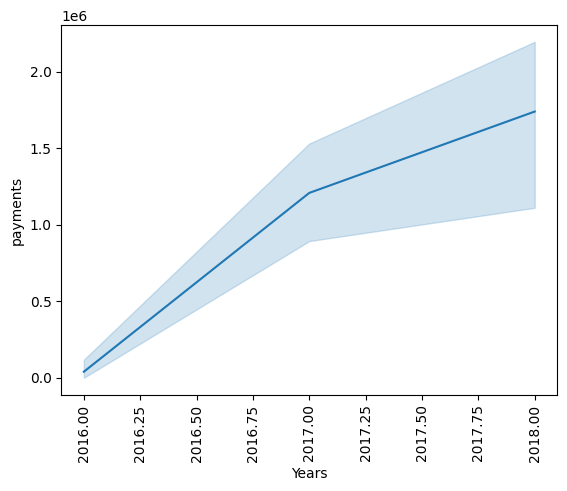

In [41]:
query = """select years, months, payments,round(sum(payments) 
over(order by years, months),2) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments from orders join payments
on orders.order_id = payments.order_id
group by years,months
order by years, months) as a;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","month","payments","cummulative_sales"])
print(df)
sns.lineplot(x = "Years",y= "payments",data= df)
plt.xticks(rotation = 90)
plt.show()


# Calculate the year-over-year growth rate of total sales.

In [47]:
query = """select years, payments, lag(payments,1) over (order by years),
((payments - lag(payments,1) over (order by years))/lag(payments,1) over (order by years))*100 
previous_sales from 
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payments from orders join payments
on orders.order_id = payments.order_id
group by years
order by years) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","Sales","Previous_year","Growth_Rate"])
df

,Years,Sales,Previous_year,Growth_Rate
0,2016,118724.68,NaN,NaN
1,2017,14499493.46,118724.68,12112.703761
2,2018,17399526.10,14499493.46,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [52]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)
select 100* (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;"""

cur.execute(query)

data = cur.fetchall()
print(data)
print("As the output is none, there is no customer who made another purchase within 6 months of their first purchase.")

[(None,)]
As the output is none, there is no customer who made another purchase within 6 months of their first purchase.


# Identify the top 3 customers who spent the most money in each year.

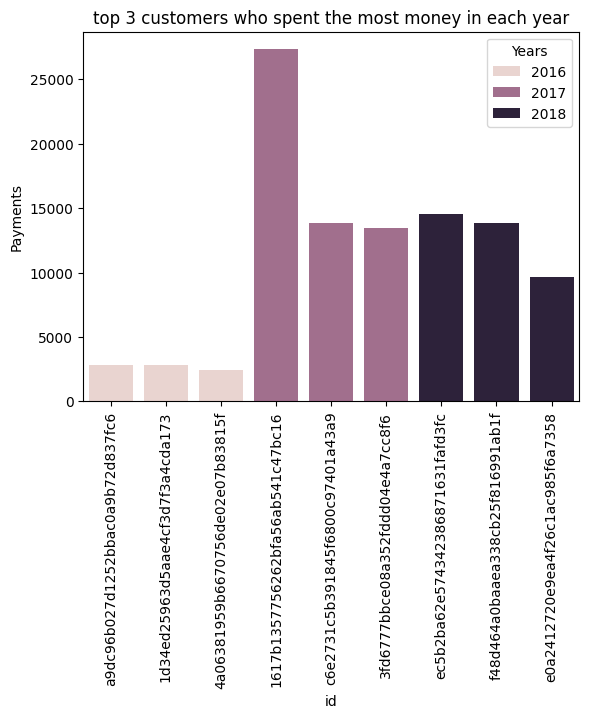

In [59]:
query = """select years, customer_id,payment, d_rank from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value ) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by orders.order_purchase_timestamp, orders.customer_id) as a
where d_rank <= 3;"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","id","Payments","Rank"])
sns.barplot(x = "id", y = "Payments",data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.title("top 3 customers who spent the most money in each year")
plt.show()